# Introduction

The fundamental goal of portfolio theory is to allocate your investments between multiple assets optimally. A Markowitz mean-variance optimization (MVO) is an approach to choosing how to allocate money between multiple assets by considering the risk-return trade-off of asset combinations.

The approach considers the expected returns and covariance for all assets. It returns a set of portfolios where:

* The expected return is greater than any other with the same or lesser risk
* The risk is less than any other with the same expected return

For example, a Markowitz optimization could recommend how to distribute your money between Nike, Under Armour, and Skechers. In this example, to make the recommendation, we will consider historical data from the last 22 quarters to split $10,000 between each company. To minimize the risk of your portfolio, you should invest the following amounts in each company:

* Nike: $8,157
* Under Armour: $1,667
* Skechers: $176

You should invest the following amounts to maximize return:

* Nike: $0
* Under Armour: $0
* Skechers: $10,000

***
### Exercise

Below we display the risk and return for a collection of portfolios from `stock_data.csv`. The yellow line is called the efficient frontier — the set of portfolios that is optimized for risk and return.

* The red triangle marks the portfolio on the efficient frontier with the lowest risk (Example 1 above).
* The red X marks the portfolio on the efficient frontier with the highest return (Example 2 above).

It is okay if this figure is confusing to you. We will go over it as we work our way through the lesson.

 8.6370e-02  5e-03  6e-17  4e-04
 3:  8.9284e-02  8.8962e-02  3e-04  6e-17  9e-06
 4:  8.9108e-02  8.9080e-02  3e-05  1e-16  4e-08
 5:  8.9092e-02  8.9089e-02  3e-06  2e-16  8e-17
 6:  8.9089e-02  8.9089e-02  2e-07  2e-16  3e-17
 7:  8.9089e-02  8.9089e-02  2e-09  8e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1682e-01 -9.3228e-01  1e+00  4e-16  3e+00
 1:  1.1368e-01  6.6196e-02  5e-02  1e-16  1e-01
 2:  1.0462e-01  9.9335e-02  5e-03  8e-17  8e-17
 3:  1.0266e-01  1.0232e-01  3e-04  2e-16  8e-17
 4:  1.0247e-01  1.0245e-01  3e-05  1e-16  4e-17
 5:  1.0246e-01  1.0245e-01  3e-06  6e-17  8e-17
 6:  1.0246e-01  1.0245e-01  1e-07  1e-16  6e-17
 7:  1.0245e-01  1.0245e-01  1e-09  2e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3288e-01 -9.2068e-01  1e+00  0e+00  3e+00
 1:  1.2940e-01  7.8882e-02  5e-02  4e-17  1e-01
 2:  1.1962e-01  1.1381e-01  6e-03  8e-17  9e-17
 3:  1.1757e-01  1.1721e-01  4e-04  1e-

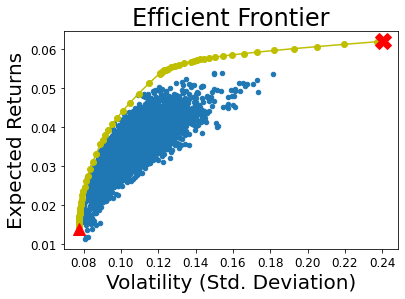

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers

path = 'stock_data.csv'

stock_data = pd.read_csv(path)
selected = list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()


def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]

    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []

    num_assets = len(selected)
    num_portfolios = 5000

    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}

    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter]
                                         for Weight in stock_weights]

    df = pd.DataFrame(portfolio)

    column_order = ['Returns', 'Volatility'] + \
        [stock+' Weight' for stock in selected]

    df = df[column_order]

    return df


df = return_portfolios(expected_returns, cov_quarterly)

weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

min_risk_idx = np.array(risks).argmin()
max_return_idx = np.array(risks).argmax()
min_risk = [risks[min_risk_idx], returns[min_risk_idx]]
max_return = [risks[max_return_idx], returns[max_return_idx]]

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.plot(min_risk[0], min_risk[1], 'r^', markersize=12)
plt.plot(max_return[0], max_return[1], 'rX', markersize=16)
plt.ylabel('Expected Returns', fontsize=20)
plt.xlabel('Volatility (Std. Deviation)', fontsize=20)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

***

## Inputs: Expected Return I

Typically, when we download stock data, the information is formatted as asset values at the end of a period (daily, monthly, quarterly). When we calculate the efficient frontiers, we need to structure the data as the percent returned over each period.

The percent return is the y-axis of a mean-variance, like the one you saw last exercise:

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_2.png" alt="Image of efficient frontier" style="background-color:white;"></img>

Before we can calculate the expected return of a portfolio, we need to find the expected return of each asset.

Let us use the following example to see how we can calculate the percent return of an asset.

Imagine you were looking at the performance of the New York Times, Twitter, and Fox over the last 18 quarters:

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_2_asset_vals.png" alt="Image of asset values over time" style="background-color:white;"></img>

If we were to print the first five timepoints, we would get:

|Date|NYTimes|Twitter|Fox|
|:---|:------|:------|:--|
|2013-12-31|16.14|62.36|34.59|
|2014-03-31|16.86|47.55|30.76|
|2014-06-30|15.21|40.81|34.42|
|2014-09-30|11.51|52.00|33.38|
|2014-12-31|13.42|35.89|37.12|

These columns display the stock value over five quarters, starting from the end of 2013. We can use the `pct_change()` method to calculate the quarterly return of each asset:
```
selected = list(my_data.columns[1:]) #Variable holds ['NYTimes','Twitter','Fox']
quarterly_returns = my_data[selected].pct_change()
```
Below is the first five quarterly returns:

|Date|NYTimes|Twitter|Fox|
|:---|:------|:------|:--|
|2013-12-31|NaN|NaN|NaN|
|2014-03-31|0.044610|-0.237492|-0.110726|
|2014-06-30|-0.097865|-0.141746|0.118986|
|2014-09-30|-0.243261|0.274198|-0.030215|
|2014-12-31|0.165943|-0.309808|0.112043|

Notice, the first row is not defined. This is because there is no data before 2013-12-31 to calculate the percent change.

When calculating the efficient frontier, we need to find the average expected return for each asset. Because we are using DataFrames, we can calculate the average expected return using the `.mean()` method:

`returns_quarterly.mean()`

This will return:

|||
|:-----|:-------|
|NYTimes|0.031148|
|Twitter|-0.004922|
|Fox|0.010805|

***
### Exercise

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = 'stock_data.csv'
stock_data = pd.read_csv(path)
stock_data

Date  Delta  Jet Blue   Chevron   Exxon   Adobe  Honeywell
0   2007-12-31  14.64      5.94   94.3700   94.39   42.58    60.8900
1   2008-03-31   8.65      5.45   84.9500   85.69   35.69    55.7200
2   2008-06-30   5.42      3.58   98.3000   86.81   39.63    49.2600
3   2008-09-30   7.50      4.70   78.8500   75.62   36.72    41.5500
4   2008-12-31  10.97      6.80   72.9000   78.42   20.85    32.6100
5   2009-03-31   5.58      3.88   67.4400   69.04   20.93    27.9900
6   2009-06-30   5.80      4.26   66.9400   70.60   28.76    32.3000
7   2009-09-30   9.18      5.92   71.1200   68.98   32.76    37.2900
8   2009-12-31  11.30      5.48   77.7200   68.84   37.17    39.7100
9   2010-03-31  14.48      5.46   75.4700   66.94   35.62    45.6300
10  2010-06-30  11.37      5.55   68.2200   57.33   26.82    38.5900
11  2010-09-30  11.61      6.75   81.6900   61.95   26.25    44.3500
12  2010-12-31  12.45      6.72   91.5800   73.16   30.52    52.9400
13  2011-03-31   9.84      6.28  109.3100   84.82   32.88    59.6100
14  2011-06-30   9.27      6.10  101.7900   80.39   31.21    58.7900
15  2011-09-30   7.86      4.18   92.9600   72.76   24.60    44.0217
16  2011-12-31   8.09      5.25  106.7900   85.16   28.26    54.7700
17  2012-03-31  10.02      5.00  107.0400   86.48   34.69    61.2300
18  2012-06-30  11.21      5.32  105.3200   84.78   31.74    54.3800
19  2012-09-30   9.14      4.88  116.8800   91.48   32.65    59.8400
20  2012-12-31  11.57      5.57  105.7500   85.04   36.80    62.7200
21  2013-03-31  16.69      6.95  120.4400   90.64   42.54    75.1500
22  2013-06-30  18.61      6.30  118.7900   89.85   45.99    80.0000
23  2013-09-30  23.16      6.60  121.5999   86.06   51.50    82.8000
24  2013-12-31  27.23      8.47  124.6800  100.49   59.60    90.8700
25  2014-03-31  33.75      8.54  118.7900   98.49   64.87    91.6600
26  2014-06-30  39.18     10.91  130.1500  101.21   72.43    93.1800
27  2014-09-30  36.01     10.38  120.5100   94.11   69.49    93.4300
28  2014-12-31  49.58     16.00  111.6500   92.42   73.40   100.9700
29  2015-03-31  45.58     19.37  105.6200   84.85   73.11   104.2500
30  2015-06-30  41.68     20.51   97.4500   83.74   82.19   102.6700
31  2015-09-30  44.72     25.45   77.1500   73.40   80.88    93.6500
32  2015-12-31  51.00     22.89   89.3800   77.51   95.07   104.0700
33  2016-03-31  49.37     21.32   95.1900   84.07   93.76   112.1100
34  2016-06-30  36.26     16.47  103.5600   92.33   94.48   115.0000
35  2016-09-30  39.15     17.31  101.8300   86.84  108.15   116.6400
36  2016-12-31  49.34     22.25  117.4400   90.03  104.07   116.2000
37  2017-03-31  46.12     20.71  107.7000   83.26  129.57   125.1100
38  2017-06-30  54.00     22.91  104.5300   81.08  141.87   133.4200
39  2017-09-30  48.40     18.57  117.1700   81.94  146.69   139.7700
40  2017-12-31  56.53     22.51  125.3600   84.00  175.19   154.3700
41  2018-03-31  55.31     20.45  115.7500   74.00  229.90   147.5800

1. Calculate the quarterly returns for the assets in the `stock_data` variable. Save the result to `quarterly_returns`.

In [3]:
quarterly_returns = stock_data[stock_data.columns[1:]].pct_change()
quarterly_returns

Delta  Jet Blue   Chevron     Exxon     Adobe  Honeywell
0        NaN       NaN       NaN       NaN       NaN        NaN
1  -0.409153 -0.082492 -0.099820 -0.092171 -0.161813  -0.084907
2  -0.373410 -0.343119  0.157151  0.013070  0.110395  -0.115937
3   0.383764  0.312849 -0.197864 -0.128902 -0.073429  -0.156516
4   0.462667  0.446809 -0.075460  0.037027 -0.432190  -0.215162
5  -0.491340 -0.429412 -0.074897 -0.119612  0.003837  -0.141674
6   0.039427  0.097938 -0.007414  0.022596  0.374104   0.153984
7   0.582759  0.389671  0.062444 -0.022946  0.139082   0.154489
8   0.230937 -0.074324  0.092801 -0.002030  0.134615   0.064897
9   0.281416 -0.003650 -0.028950 -0.027600 -0.041700   0.149081
10 -0.214779  0.016484 -0.096065 -0.143561 -0.247052  -0.154284
11  0.021108  0.216216  0.197449  0.080586 -0.021253   0.149261
12  0.072351 -0.004444  0.121067  0.180952  0.162667   0.193687
13 -0.209639 -0.065476  0.193601  0.159377  0.077326   0.125992
14 -0.057927 -0.028662 -0.068795 -0.052228 -0.050791  -0.013756
15 -0.152104 -0.314754 -0.086747 -0.094912 -0.211791  -0.251204
16  0.029262  0.255981  0.148774  0.170423  0.148780   0.244159
17  0.238566 -0.047619  0.002341  0.015500  0.227530   0.117948
18  0.118762  0.064000 -0.016069 -0.019658 -0.085039  -0.111873
19 -0.184657 -0.082707  0.109761  0.079028  0.028670   0.100405
20  0.265864  0.141393 -0.095226 -0.070398  0.127106   0.048128
21  0.442524  0.247756  0.138913  0.065851  0.155978   0.198182
22  0.115039 -0.093525 -0.013700 -0.008716  0.081100   0.064538
23  0.244492  0.047619  0.023654 -0.042181  0.119809   0.035000
24  0.175734  0.283333  0.025330  0.167674  0.157282   0.097464
25  0.239442  0.008264 -0.047241 -0.019902  0.088423   0.008694
26  0.160889  0.277518  0.095631  0.027617  0.116541   0.016583
27 -0.080909 -0.048579 -0.074068 -0.070151 -0.040591   0.002683
28  0.376840  0.541426 -0.073521 -0.017958  0.056267   0.080702
29 -0.080678  0.210625 -0.054008 -0.081909 -0.003951   0.032485
30 -0.085564  0.058854 -0.077353 -0.013082  0.124196  -0.015156
31  0.072937  0.240858 -0.208312 -0.123477 -0.015939  -0.087854
32  0.140429 -0.100589  0.158522  0.055995  0.175445   0.111265
33 -0.031961 -0.068589  0.065003  0.084634 -0.013779   0.077256
34 -0.265546 -0.227486  0.087929  0.098251  0.007679   0.025778
35  0.079702  0.051002 -0.016705 -0.059461  0.144687   0.014261
36  0.260281  0.285384  0.153295  0.036734 -0.037725  -0.003772
37 -0.065261 -0.069213 -0.082936 -0.075197  0.245027   0.076678
38  0.170859  0.106229 -0.029434 -0.026183  0.094929   0.066422
39 -0.103704 -0.189437  0.120922  0.010607  0.033975   0.047594
40  0.167975  0.212170  0.069898  0.025140  0.194287   0.104457
41 -0.021581 -0.091515 -0.076659 -0.119048  0.312290  -0.043985

2. Calculate the mean expected return for each asset and save the result to `expected_returns_avg`.

In [4]:
expected_returns_avg = quarterly_returns.mean()
expected_returns_avg

Delta        0.062093
Jet Blue     0.052361
Chevron      0.010323
Exxon       -0.002444
Adobe        0.053780
Honeywell    0.028439
dtype: float64

## Inputs: Expected Return II

Estimating the expected return of an asset is at the core of all financial investments. People often invest based on their interest in a company's product – maybe they make your favorite sneakers or use artificial intelligence to optimize a green energy grid. Investing based on feeling is not smart.

To estimate the return and volatility of a portfolio with multiple assets, we need first to calculate the amount that we invest in each asset.

### Weight of an Asset

The weight of an asset is the fraction of the money invested in the asset (the numerator of the fraction below), divided by the total amount of money in the portfolio (the denominator of the fraction below):

$$
w_n = \frac{c_n}{total}
$$​​

Let us say you had $5,000 that you want to invest in four companies. Below, we calculate the weight of each asset, given the amount invested.

Company 1: $500

$$
w_{1} = \frac{\$500}{\$5,000}
$$

Company 2: $1,500

$$
w_2 = \frac{\$1,500}{\$5,000}
$$

Company 3: $1,250

$$
w_3 = \frac{\$1,250}{\$5,000}
$$

Company 4: $1,750

$$
w_4 = \frac{\$1,750}{\$5,000}
$$

The sum of the weights of all these assets is equal to one.

In Python, we could use the code below to do the same calculation:
```
w_1 = 500 / 5000
w_2 = 1500 / 5000
w_3 = 1250 / 5000
w_4 = 1750 / 5000
```

***
### Exercise

1. You have \$10,000 dollars to invest in three companies. You choose to invest \$3,000 in Nike, \$2,000 in Under Armour, and \$5,000 in Skechers. Calculate the weights of each, and save them to `weight_nike`, `weight_ua`, and `weight_skechers`.

In [5]:
total_amount = 10000
nike_amount = 3000
ua_amount = 2000
skechers_amount = 5000

weight_nike = nike_amount / total_amount
weight_ua = ua_amount / total_amount
weight_skechers = skechers_amount / total_amount

In [6]:
try:
  print(f'The weight invested in Nike is {weight_nike:.0%}')
except:
  print('You did not create the weight_nike variable yet')
try:
  print(f'The weight invested in Under Armour is {weight_ua:.0%}')
except:
  print('You did not create the weight_ua variable yet')
try:
  print(f'The weight invested in Skechers is {weight_skechers:.0%}')
except:
  print('You did not create the weight_skechers variable yet')

The weight invested in Nike is 30%
The weight invested in Under Armour is 20%
The weight invested in Skechers is 50%


***

## Inputs: Expected Return III

In the last exercise, you calculated the expected return of individual assets. But we are interested in the return of a portfolio with multiple assets. To calculate the expected return of a portfolio, you must find the weighted sum of the return for each individual asset:

$$
ER = w_1 R_1 + w_2 R_2 + w_3 R_3 + w_4​
$$​

Let us use the weights of our assets from the last exercise, and the expected quarterly returns for each asset below to calculate the expected return of the portfolio:

|Company|Weight|Return|
|:------|:-----|:-----|
|Company 1|.1|3%|
|Company 2|.3|7%|
|Company 3|.25|12%|
|Company 4|.35|2%|

$$
ER = .1*3 + .3*7 + .25*12 + .35*2 = 6.1\%
$$

The expected return is equal to $6.1\%$. This value falls in the middle of the expected return range of the four companies, which is always the case when taking a weighted average of multiple assets.
In Python

The code below shows how you would calculate the expected return of a portfolio in Python:

```
ER = .1*3 + .3*7 + .25*12 + .35*2
```

The expected return of a portfolio is plotted on the y-axis of a mean-variance plot:

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_2.png" alt="Image of efficient frontier" style="background-color:white;"></img>

***
### Exercise

1. Calculate the expected return of a portfolio with the following asset weights and expected returns:

|Company|Weight|Return|
|:------|:-----|:-----|
|Nike|.8|1.4%|
|Under Armour|.16|.8%|
|Skechers|.04|7.0%|

Save the value to a variable called `expected_return`.

In [7]:
import json

with open('portfolio.json') as f:
    portfolio = json.load(f)

for investment in portfolio.values():
    for item in investment:
        print(item)

{'name': 'Nike', 'weight': 0.8, 'return': 0.014}
{'name': 'Under Armour', 'weight': 0.16, 'return': 0.008}
{'name': 'Skechers', 'weight': 0.04, 'return': 0.07}


In [8]:
expected_return = 0

for investment in portfolio.values():
    for item in investment:
        expected_return += item['weight'] * item['return']

expected_return

0.015280000000000002

In [9]:
try:
  print('The expected return is equal to {:.2f}%'.format(expected_return))
except:
  print('You did not create the expected_return variable yet')

The expected return is equal to 0.02%


***

## Inputs: Covariance Matrix I

It would be nice if every asset made large, consistent positive returns every period. If that were the case, we could invest all of our money in the asset with the highest expected return. But, the return of any given asset is unpredictable.

### Variance Measures an Asset's Risk

The measure of an asset's unpredictability is called its *risk*. We can estimate the risk of an asset by calculating its variance. If an asset's return is very unpredictable, then its variance will be large and the investment considered risky. If an asset's variance is small, the asset's returns are predictable and the asset is not as risky.

When we quantify the risk of a portfolio, in addition to the variance of each asset, we must calculate the covariance between each asset and every other asset. If two assets have a positive covariance, then they respond similarly to market forces. Assets with a negative covariance will not. For example:

* Oil prices affect car sales, which will impact automobile company returns (Ford, Honda, Toyota, General Motors)
* Increasing farm subsidies make crop production cheaper, which will increase agriculture returns. Agriculture companies, like Tyson, Monsanto, and Cargill will likely all increase in value (positive covariance).
* Tariffs on electronics may affect cell phone sales, which will decrease returns for hardware manufacturing companies, like Huawei, Apple, and Google (positive covariance).

Assets can have a positive covariance, negative covariance, or no covariance:

* **Positive covariance** — when one asset increases in value, the other usually increases in value. The covariance value will be greater than 0.
* **Negative covariance** — when one asset increases in value, the other usually decreases in value. The covariance value will be less than 0.
* **Uncorrelated assets** — when there is no quantifiable pattern to the response of two assets. The covariance value is equal to 0.

***
### Exercise

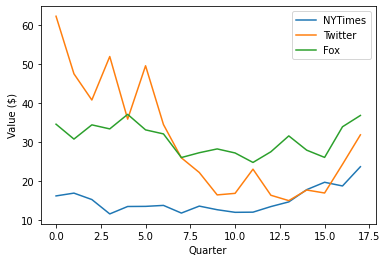

In [10]:
path = 'stock_data2.csv'
stock_data = pd.read_csv(path)
stock_data.plot()
plt.xlabel('Quarter')
plt.ylabel('Value ($)')
plt.show()

1. The figure to the right shows the returns of three companies over the last 18 quarters. It is hard to tell by inspecting this figure whether these assets are postively covarying, negatively covarying, or uncorrelated. In the next exercise, you will learn how to calculate the covariance of these assets. In the meantime, take a guess!

    We are not checking that you get the correct answer. We just want you to think about it and give your best guess.

    Set the variables `nytimes_to_fox`, `nytimes_to_twitter`, and `twitter_to_fox` equal to:

* "Positive" — if you think the companies are positively correlated
* "Negative" — if you think the companies are negatively correlated
* "None" — if you think the companies are uncorrelated

In [11]:
nytimes_to_fox = 'Positive'
nytimes_to_twitter = 'None'
twitter_to_fox = 'Negative'

***

## Inputs: Covariance Matrix II

To make computations more manageable, we store variances and covariances of assets in a covariance matrix. A covariance matrix is symmetric, with the variance of each asset on the diagonal. For example, the covariance matrix of a three-asset portfolio would look like:

\begin{bmatrix} \sigma_1 & \sigma_{1,2} & \sigma_{1,3} \\ \sigma_{1,2} & \sigma_2 & \sigma_{2,3} \\ \sigma_{1,3} & \sigma_{2,3} & \sigma_3 \\ \end{bmatrix}

Below, we have a DataFrame with the monthly returns of three companies: The New York Times, Twitter, and Fox.

`print(portfolio.head())`

|Date|NYTimes|Twitter|Fox|
|:---|:------|:------|:--|
|2013-12-31|16.14|62.36|34.59|
|2014-03-31|16.86|47.55|30.76|
|2014-06-30|15.21|40.81|34.42|
|2014-09-30|11.51|52.00|33.38|
|2014-12-31|13.42|35.89|37.12|

To calculate the covariance of these assets, we can use the pandas `.cov()` function:

`portfolio.cov()`

The output of this function is:

|       |NYTimes|Twitter|Fox|
|:------|:------|:------|:--|
|NYTimes|10.670941|-0.180665|4.475743|
|Twitter|-0.180665|214.828332|35.534395|
|Fox|4.475743|35.534395|15.381445|

This matrix shows:

* A small negative covariance between the New York Times and Twitter
* A positive covariance between the New York Times and Fox
* A large positive covariance between Fox and Twitter.

***
### Exercise

In [12]:
path = 'stock_data.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()

1. We loaded a new data frame of assets and saved it to a variable called `stock_data`.

    Print the `stock_data`, and take a look at the table.

    You should see seven columns containing the date and the following six companies:

* Delta
* Jet Blue
* Chevron
* Exxon
* Adobe
* Honeywell

In [13]:
stock_data

Date  Delta  Jet Blue   Chevron   Exxon   Adobe  Honeywell
0   2007-12-31  14.64      5.94   94.3700   94.39   42.58    60.8900
1   2008-03-31   8.65      5.45   84.9500   85.69   35.69    55.7200
2   2008-06-30   5.42      3.58   98.3000   86.81   39.63    49.2600
3   2008-09-30   7.50      4.70   78.8500   75.62   36.72    41.5500
4   2008-12-31  10.97      6.80   72.9000   78.42   20.85    32.6100
5   2009-03-31   5.58      3.88   67.4400   69.04   20.93    27.9900
6   2009-06-30   5.80      4.26   66.9400   70.60   28.76    32.3000
7   2009-09-30   9.18      5.92   71.1200   68.98   32.76    37.2900
8   2009-12-31  11.30      5.48   77.7200   68.84   37.17    39.7100
9   2010-03-31  14.48      5.46   75.4700   66.94   35.62    45.6300
10  2010-06-30  11.37      5.55   68.2200   57.33   26.82    38.5900
11  2010-09-30  11.61      6.75   81.6900   61.95   26.25    44.3500
12  2010-12-31  12.45      6.72   91.5800   73.16   30.52    52.9400
13  2011-03-31   9.84      6.28  109.3100   84.82   32.88    59.6100
14  2011-06-30   9.27      6.10  101.7900   80.39   31.21    58.7900
15  2011-09-30   7.86      4.18   92.9600   72.76   24.60    44.0217
16  2011-12-31   8.09      5.25  106.7900   85.16   28.26    54.7700
17  2012-03-31  10.02      5.00  107.0400   86.48   34.69    61.2300
18  2012-06-30  11.21      5.32  105.3200   84.78   31.74    54.3800
19  2012-09-30   9.14      4.88  116.8800   91.48   32.65    59.8400
20  2012-12-31  11.57      5.57  105.7500   85.04   36.80    62.7200
21  2013-03-31  16.69      6.95  120.4400   90.64   42.54    75.1500
22  2013-06-30  18.61      6.30  118.7900   89.85   45.99    80.0000
23  2013-09-30  23.16      6.60  121.5999   86.06   51.50    82.8000
24  2013-12-31  27.23      8.47  124.6800  100.49   59.60    90.8700
25  2014-03-31  33.75      8.54  118.7900   98.49   64.87    91.6600
26  2014-06-30  39.18     10.91  130.1500  101.21   72.43    93.1800
27  2014-09-30  36.01     10.38  120.5100   94.11   69.49    93.4300
28  2014-12-31  49.58     16.00  111.6500   92.42   73.40   100.9700
29  2015-03-31  45.58     19.37  105.6200   84.85   73.11   104.2500
30  2015-06-30  41.68     20.51   97.4500   83.74   82.19   102.6700
31  2015-09-30  44.72     25.45   77.1500   73.40   80.88    93.6500
32  2015-12-31  51.00     22.89   89.3800   77.51   95.07   104.0700
33  2016-03-31  49.37     21.32   95.1900   84.07   93.76   112.1100
34  2016-06-30  36.26     16.47  103.5600   92.33   94.48   115.0000
35  2016-09-30  39.15     17.31  101.8300   86.84  108.15   116.6400
36  2016-12-31  49.34     22.25  117.4400   90.03  104.07   116.2000
37  2017-03-31  46.12     20.71  107.7000   83.26  129.57   125.1100
38  2017-06-30  54.00     22.91  104.5300   81.08  141.87   133.4200
39  2017-09-30  48.40     18.57  117.1700   81.94  146.69   139.7700
40  2017-12-31  56.53     22.51  125.3600   84.00  175.19   154.3700
41  2018-03-31  55.31     20.45  115.7500   74.00  229.90   147.5800

2. Calculate the covariance matrix of the assets in the data frame and save it to `returns_cov`.

    Notice, all of the assets in the portfolio are positively covarying. This is fairly common, as companies move either with the market or have no covariance. Few companies are negatively covarying.

In [14]:
returns_cov = returns_quarterly.cov()
returns_cov

Delta  Jet Blue   Chevron     Exxon     Adobe  Honeywell
Delta      0.057825  0.037921 -0.000407  0.002053  0.004228   0.008055
Jet Blue   0.037921  0.044951 -0.001776  0.002404 -0.001467   0.005532
Chevron   -0.000407 -0.001776  0.010988  0.007023  0.004638   0.007022
Exxon      0.002053  0.002404  0.007023  0.007233  0.003111   0.006190
Adobe      0.004228 -0.001467  0.004638  0.003111  0.022535   0.011297
Honeywell  0.008055  0.005532  0.007022  0.006190  0.011297   0.013206

***

## Efficient Frontier I

Now we are ready to visualize the mean-variance tradeoff for a collection of random portfolios. In this exercise, we provide you with a function, called `return_portfolios()` that accepts the expected returns and covariance matrix for a collection of assets. The function returns a DataFrame with 5,000 portfolios of random asset weights. We will not step through how we implemented the function in this exercise. If you are interested, you can see the function in `rf.py`.

Below, we read in stock data from `my_stock_data.csv`, and calculate the expected quarterly returns and covariance matrix for the assets.
```
stock_data = pd.read_csv('my_stock_data.csv')
selected=list(stock_data.columns[1:])
 
returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()
```
Now that we have the quarterly returns and covariance matrix, we can pass these values to `return_portfolios()` (imported from `rf.py`):
```
my_portfolios = return_portfolios(expected_returns, cov_quarterly) 
```
The `return_portfolios()` function returns a DataFrame with 5,000 portfolios. Each portfolio includes the following columns:

* `'Returns'` — the expected return of the portfolio
* `'Volatility'` — the standard deviation of the portfolio
* `'Weight Asset 1'` … `'Weight Asset N'` — the weights of each asset in the given portfolio.

***
### Exercise

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from rf import return_portfolios
import numpy as np
import random

returns_quarterly = pd.read_csv('stock_data.csv')
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

1. Use `return_portfolios()` to calculate 5,000 random portfolios. Save the output to a variable called `random_portfolios`.

In [16]:
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

2. Use the following code to print the first five random portfolios:

    `print(random_portfolios.head().round(4))`

In [17]:
random_portfolios.head().round(4)

Returns  Volatility  Delta Weight  Jet Blue Weight  Chevron Weight  \
0  61.3220     20.1048        0.1773           0.1612          0.2062   
1  64.2277     21.9879        0.0515           0.1770          0.1264   
2  65.7953     18.9193        0.0189           0.2132          0.2006   
3  65.0713     23.3359        0.2146           0.0387          0.2207   
4  59.2669     17.1823        0.2771           0.0970          0.1180   

   Exxon Weight  Adobe Weight  Honeywell Weight  
0        0.1021        0.1159            0.2374  
1        0.1857        0.2078            0.2515  
2        0.2064        0.1663            0.1946  
3        0.1440        0.3323            0.0496  
4        0.2653        0.1056            0.1370

***

## Efficient Frontier II

When we have a set of portfolios, we typically plot them on a two-dimensional scatter plot, with standard deviation on the x-axis and expected return on the y-axis.

In the last exercise, we showed you that `return_portfolios()` returns a DataFrame with the expected return and volatility for each portfolio. You can plot these portfolios with the following code:
```
df.plot.scatter(x='Volatility', y='Returns')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
```

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_8.png" alt="Scatter plot of expected return and volatility for each portfolio" style="background-color:white;"></img>

The figure above displays a characteristic boomerang shape. Given that our goal is to minimize volatility and maximize expected return, the portfolios that fall on the left-most edge are the best portfolios. As you will see in the next exercise, the efficient frontier falls on the top left edge of this boomerang.

***
### Exercise

1. In the last exercise, you calculated 5,000 random portfolios. Plot the mean vs the variance for these portfolios. Your figure should include the following information:

* X-label: 'Volatility (Std. Deviation)'
* Y-label: 'Expected Returns'
* Title: 'Efficient Frontier'

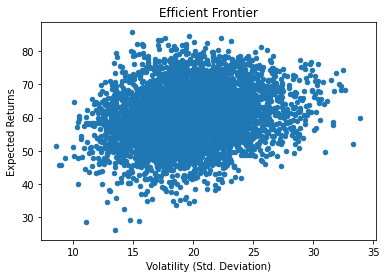

In [18]:
random_portfolios.plot.scatter(x='Volatility', y='Returns')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

***

## Efficient Frontier III

At this point, we know how to visualize the range of possible portfolios. We still have not found the set of portfolios that optimize for both the expected return and risk of our assets. In this exercise, you will use a function that we developed, called `optimal_portfolio()`, to find mean-variance optimized portfolios. If you are interested in how we wrote the function, you can read through the code in `rf.py`.

The `optimal_portfolio()` function has one parameter:

* `returns` — the returns for all assets over a specified timeframe

The `optimal_portfolio()` function returns:

* `weights` — the weights for each asset in the portfolio
* `returns` — the expected returns of each portfolio
* `risks` — the risk of each portfolio, measured as standard deviation

In the example below, we calculate the efficient frontier, then plot it on top of all possible portfolios:
```
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])
 
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
```
The resulting figure looks like:

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_9.png" alt="Image of efficient frontier" style="background-color:white;"></img>

Notice, the yellow line is on top of the top-left edge of the portfolio range. This line falls on the portfolios that maximize the expected return at all risks, and minimize the risk at all expected returns.

To access the weights of these portfolios, you can print them with:
```
print(weights)
```
You can feel rest-assured that whichever portfolio you select is optimized for historical risk and return data.

***
### Exercise

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from rf import return_portfolios, optimal_portfolio
import numpy as np

path = 'stock_data.csv'
stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

random_portfolios = return_portfolios(expected_returns, cov_quarterly) 

1. Use the `optimal_portfolio()` function to calculate the efficent frontier. Save the function return values to `weights`, `returns`, and `risks`.

    We added the following code at the bottom of script.py to plot the efficient frontier as a yellow line.

    `plt.plot(risks, returns, 'y-o')`

In [20]:
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

 8.6370e-02  5e-03  6e-17  4e-04
 3:  8.9284e-02  8.8962e-02  3e-04  6e-17  9e-06
 4:  8.9108e-02  8.9080e-02  3e-05  1e-16  4e-08
 5:  8.9092e-02  8.9089e-02  3e-06  2e-16  8e-17
 6:  8.9089e-02  8.9089e-02  2e-07  2e-16  3e-17
 7:  8.9089e-02  8.9089e-02  2e-09  8e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1682e-01 -9.3228e-01  1e+00  4e-16  3e+00
 1:  1.1368e-01  6.6196e-02  5e-02  1e-16  1e-01
 2:  1.0462e-01  9.9335e-02  5e-03  8e-17  8e-17
 3:  1.0266e-01  1.0232e-01  3e-04  2e-16  8e-17
 4:  1.0247e-01  1.0245e-01  3e-05  1e-16  4e-17
 5:  1.0246e-01  1.0245e-01  3e-06  6e-17  8e-17
 6:  1.0246e-01  1.0245e-01  1e-07  1e-16  6e-17
 7:  1.0245e-01  1.0245e-01  1e-09  2e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3288e-01 -9.2068e-01  1e+00  0e+00  3e+00
 1:  1.2940e-01  7.8882e-02  5e-02  4e-17  1e-01
 2:  1.1962e-01  1.1381e-01  6e-03  8e-17  9e-17
 3:  1.1757e-01  1.1721e-01  4e-04  1e-

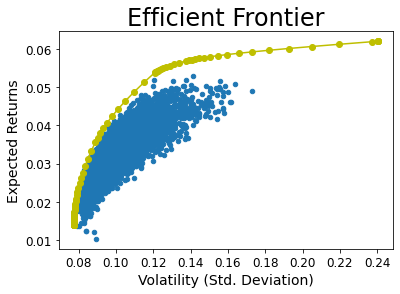

In [21]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
try:
	plt.plot(risks, returns, 'y-o')
except:
  pass
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

***

## Diverse Portfolios Decrease Variance I

In the last exercise, you found the efficient frontier of a portfolio with Delta, Jet Blue, Chevron, Exxon, Adobe, and Honeywell stocks.

The red X marks in the figure below display the volatility and expected return for each individual asset:

|Company|Return|Standard Dev|
|:------|:-----|:-----------|
|Delta|6.2%|0.24|
|Jet Blue|5.2%|0.21|
|Chevron|1.0%|0.10|
|Exxon|-0.2%|0.05|
|Adobe|5.4%|0.15|
|Honeywell|2.8%|0.11|

The vertical red lines in the figure below display the standard deviation of each asset. Notice, there are a few portfolios (blue dots) with volatility lower than the least volatile asset. This feature results from having multiple, uncorrelated assets in the same portfolio.

An important feature that results from this is that **increasing the number of uncorrelated assets will decrease or not affect the risk of the portfolio**.

***
### Exercise

 8.6370e-02  5e-03  6e-17  4e-04
 3:  8.9284e-02  8.8962e-02  3e-04  6e-17  9e-06
 4:  8.9108e-02  8.9080e-02  3e-05  1e-16  4e-08
 5:  8.9092e-02  8.9089e-02  3e-06  2e-16  8e-17
 6:  8.9089e-02  8.9089e-02  2e-07  2e-16  3e-17
 7:  8.9089e-02  8.9089e-02  2e-09  8e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1682e-01 -9.3228e-01  1e+00  4e-16  3e+00
 1:  1.1368e-01  6.6196e-02  5e-02  1e-16  1e-01
 2:  1.0462e-01  9.9335e-02  5e-03  8e-17  8e-17
 3:  1.0266e-01  1.0232e-01  3e-04  2e-16  8e-17
 4:  1.0247e-01  1.0245e-01  3e-05  1e-16  4e-17
 5:  1.0246e-01  1.0245e-01  3e-06  6e-17  8e-17
 6:  1.0246e-01  1.0245e-01  1e-07  1e-16  6e-17
 7:  1.0245e-01  1.0245e-01  1e-09  2e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3288e-01 -9.2068e-01  1e+00  0e+00  3e+00
 1:  1.2940e-01  7.8882e-02  5e-02  4e-17  1e-01
 2:  1.1962e-01  1.1381e-01  6e-03  8e-17  9e-17
 3:  1.1757e-01  1.1721e-01  4e-04  1e-

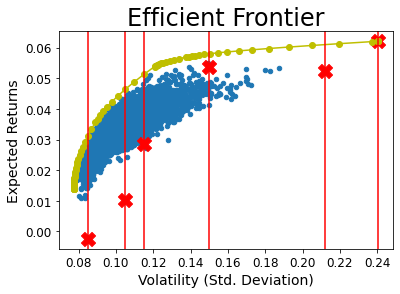

In [22]:
path='stock_data.csv'
#path='stock_data_nvidia.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
df = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
for xc in single_asset_std:
    plt.axvline(x=xc, color='red')

if 'nvidia' in path:
  plt.axvline(single_asset_std[-1], color='green')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='green',s=200)
  original_EF=np.genfromtxt("stock_risks_returns.csv", delimiter=',')
  plt.plot(risks, returns, 'g-o')
  plt.plot(original_EF[:,0],original_EF[:,1], 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

1. On line 2 in the cell above, we commented out the following code:

    `path='stock_data_nvidia.csv'`
    
    This file includes all the same data as `stock_data.csv`, but with an additional asset, Nvidia.
    
    Nvidia is a risky, high-return asset, with a standard deviation near `.225` and expected return above `.07`.
    
    Given this information, how do you expect the efficient frontier to change if we added Nvidia to our portfolio?
    
    When you are done thinking, uncomment line 2 and run the code. The new frontier will be plotted in green.
    
    Does the result make sense?

-07
 5:  1.3402e-01  1.3402e-01  3e-06  2e-16  8e-17
 6:  1.3402e-01  1.3402e-01  9e-08  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7447e-01 -8.9560e-01  1e+00  0e+00  3e+00
 1:  1.6929e-01  1.0716e-01  6e-02  4e-17  2e-01
 2:  1.5581e-01  1.4796e-01  8e-03  1e-16  6e-04
 3:  1.5292e-01  1.5246e-01  5e-04  1e-16  2e-05
 4:  1.5266e-01  1.5263e-01  3e-05  2e-16  1e-07
 5:  1.5264e-01  1.5264e-01  3e-06  7e-17  1e-16
 6:  1.5264e-01  1.5264e-01  6e-08  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9601e-01 -8.7771e-01  1e+00  1e-16  3e+00
 1:  1.9045e-01  1.2647e-01  6e-02  1e-16  2e-01
 2:  1.7658e-01  1.6876e-01  8e-03  1e-16  6e-04
 3:  1.7372e-01  1.7328e-01  4e-04  1e-16  1e-05
 4:  1.7348e-01  1.7346e-01  3e-05  4e-17  1e-07
 5:  1.7347e-01  1.7346e-01  2e-06  2e-16  1e-16
 6:  1.7346e-01  1.7346e-01  4e-08  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   d

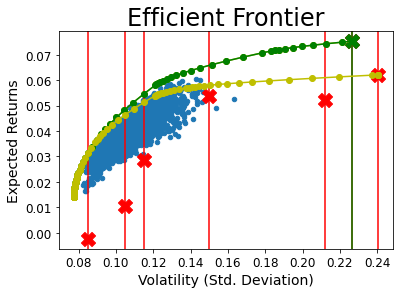

In [23]:
#path='stock_data.csv'
path='stock_data_nvidia.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
df = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
for xc in single_asset_std:
    plt.axvline(x=xc, color='red')

if 'nvidia' in path:
  plt.axvline(single_asset_std[-1], color='green')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='green',s=200)
  original_EF=np.genfromtxt("stock_risks_returns.csv", delimiter=',')
  plt.plot(risks, returns, 'g-o')
  plt.plot(original_EF[:,0],original_EF[:,1], 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

***

## Diverse Portfolios Decrease Variance II

In the last exercise, you added Nvidia to your portfolio. Nvidia is a high-risk, high-return asset. Despite Nvidia's risk, it improved the efficient frontier by increasing the expected return at most standard deviations. This is evident by the shift of the efficient frontier up and to the left:

<img src="https://content.codecademy.com/programs/python-for-finance/portfolio-optimization/exercise_11.png" alt="Image of efficient frontier shifted up and to the left" style="background-color:white;"></img>

In this example, a high-risk, high-return asset increased the expected return of portfolios on the efficient frontier. This is because the new asset had a larger expected return than any other asset.

Now let us think about how we can decrease the risk of portfolios on the efficient frontier. What kind of asset do you think we should choose to decrease the risk of portfolios on the efficient frontier?

*To decrease the risk of portfolios on an efficient frontier, you should add assets that are uncorrelated to assets in your portfolio.*

Unlike with expected return, the risk of an individual asset does not indicate whether it will affect the risk of the overall portfolio. An uncorrelated asset increases the diversity of your portfolio, which protects you from a downturn that may affect a subset of your assets.

***
### Exercise

-07
 5:  1.3402e-01  1.3402e-01  3e-06  2e-16  8e-17
 6:  1.3402e-01  1.3402e-01  9e-08  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7447e-01 -8.9560e-01  1e+00  0e+00  3e+00
 1:  1.6929e-01  1.0716e-01  6e-02  4e-17  2e-01
 2:  1.5581e-01  1.4796e-01  8e-03  1e-16  6e-04
 3:  1.5292e-01  1.5246e-01  5e-04  1e-16  2e-05
 4:  1.5266e-01  1.5263e-01  3e-05  2e-16  1e-07
 5:  1.5264e-01  1.5264e-01  3e-06  7e-17  1e-16
 6:  1.5264e-01  1.5264e-01  6e-08  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9601e-01 -8.7771e-01  1e+00  1e-16  3e+00
 1:  1.9045e-01  1.2647e-01  6e-02  1e-16  2e-01
 2:  1.7658e-01  1.6876e-01  8e-03  1e-16  6e-04
 3:  1.7372e-01  1.7328e-01  4e-04  1e-16  1e-05
 4:  1.7348e-01  1.7346e-01  3e-05  4e-17  1e-07
 5:  1.7347e-01  1.7346e-01  2e-06  2e-16  1e-16
 6:  1.7346e-01  1.7346e-01  4e-08  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   d

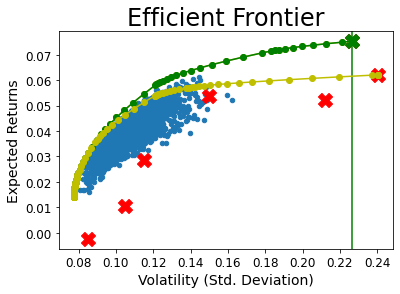

In [24]:
#path='stock_data.csv'
path='stock_data_nvidia.csv'
#path='stocks_nvidia_dexcom.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
df = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)


if 'dexcom' in path:
  plt.axvline(single_asset_std[-1], color='black')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='black',s=200)
  plt.scatter(single_asset_std[-2],expected_returns[-2],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  nvidia_EF=pd.read_csv('./risks_returns_nvidia.csv')
  plt.plot(risks, returns, 'k-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  plt.plot(nvidia_EF['risks'],nvidia_EF['returns'], 'g-o')
elif 'nvidia' in path:
  plt.axvline(single_asset_std[-1], color='green')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  plt.plot(risks, returns, 'g-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

1. We added an asset called Dexcom to our portfolio and saved it to a file called `stocks_nvidia_dexcom.csv`. Dexcom, like Nvidia, is a high-risk high-return asset.

    However, Dexcom is uncorrelated to most of the assets in the portfolio.

    How do you think Dexcom will affect the efficient frontier of the portfolio?

    When you are ready, uncomment line 3 and run the code.

    Adding Dexcom does two things:

* Increases the expected return at every standard deviation on the efficient frontier.
* Decreases the risk at every expected return on the efficient frontier.

 7.9101e-02  3e-05  1e-16  5e-17
 5:  7.9117e-02  7.9117e-02  4e-07  2e-16  1e-16
 6:  7.9117e-02  7.9117e-02  4e-09  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0875e-01 -9.5777e-01  1e+00  2e-16  3e+00
 1:  1.0484e-01  4.3374e-02  6e-02  7e-17  2e-01
 2:  9.3983e-02  8.5265e-02  9e-03  8e-17  2e-16
 3:  9.2100e-02  9.1293e-02  8e-04  6e-17  1e-16
 4:  9.1741e-02  9.1712e-02  3e-05  1e-16  7e-17
 5:  9.1727e-02  9.1727e-02  3e-07  2e-16  8e-17
 6:  9.1727e-02  9.1727e-02  3e-09  4e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2403e-01 -9.4746e-01  1e+00  0e+00  3e+00
 1:  1.1958e-01  5.5444e-02  6e-02  2e-16  2e-01
 2:  1.0812e-01  9.9131e-02  9e-03  2e-16  1e-16
 3:  1.0614e-01  1.0536e-01  8e-04  1e-16  1e-16
 4:  1.0579e-01  1.0577e-01  2e-05  9e-17  1e-16
 5:  1.0578e-01  1.0578e-01  3e-07  1e-16  1e-16
 6:  1.0578e-01  1.0578e-01  3e-09  6e-17  1e-16
Optimal solution found.
     pcost     

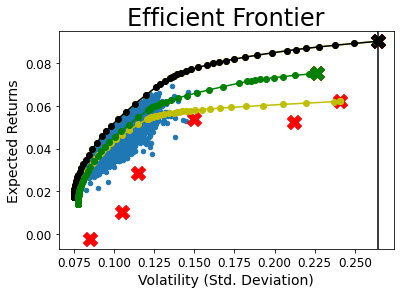

In [25]:
#path='stock_data.csv'
#path='stock_data_nvidia.csv'
path='stocks_nvidia_dexcom.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
df = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)


if 'dexcom' in path:
  plt.axvline(single_asset_std[-1], color='black')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='black',s=200)
  plt.scatter(single_asset_std[-2],expected_returns[-2],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  nvidia_EF=pd.read_csv('./risks_returns_nvidia.csv')
  plt.plot(risks, returns, 'k-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  plt.plot(nvidia_EF['risks'],nvidia_EF['returns'], 'g-o')
elif 'nvidia' in path:
  plt.axvline(single_asset_std[-1], color='green')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  plt.plot(risks, returns, 'g-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

***

## Review

In this lesson, you learned how to find the efficient frontier – a set of portfolios that minimizes risk and maximizes expected return. You also learned:

* How to calculate the weight of each asset in a portfolio, and use them to calculate the expected return of the portfolio
* Why the covariance matrix is important for evaluating the risk of a portfolio, and how to calculate it using Pandas
* How to use a function that returns portfolios from a wide range of mean-variance combinations for a given set of assets
* How to plot the entire range of possible mean-variance combinations for a given set of assets
* Where the efficient frontier falls on the mean-variance plot and why it falls there
* That adding an uncorrelated asset will decrease the risk of portfolios on the efficient frontier

***
### Exercise

In `rf.py`, we included the `return_portfolios()` and `optimal_portfolio()` functions. The specifics of how these functions were implemented is outside the scope of this lesson. However, we recommend that you take some time to look through them now. While you do not need to understand every line, it is important for you to know how to use them.